In [13]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

First we need a way to process the log files:

In [14]:
def read_job_logs(file_path):
    # Initialize lists to hold data
    timestamps = []
    events = []
    jobs = []
    cores = []
    threads = []

    # Open the file and read line by line
    with open(file_path, "r") as file:
        for line in file:
            # Parse the line with regex
            match = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6})\s(\w+)\s(\w+)(?:\s\[(.*?)\])?(?:\s*(\d+))?", line.strip())
            if match:
                # Extract fields
                timestamp, event, job, core_str, thread = match.groups()
                # Convert cores to list of ints if it's not None
                core = list(map(int, core_str.split(','))) if core_str else None
                # Add data to lists
                timestamps.append(timestamp)
                events.append(event)
                jobs.append(job)
                cores.append(core)
                threads.append(int(thread) if thread else None)

    # Create a DataFrame
    df_job = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'event': events,
        'job': jobs,
        'cores': cores,
        'threads': threads
    })
    df_job["elapsed_time"] = (df_job["timestamp"] - df_job["timestamp"].min()).dt.total_seconds() / 60  # Convert to minutes

    print(df_job.head())

    # Display DataFrame
    return df_job

Now we process the mcper file:

In [15]:
def read_log(file_path, start_timestamp_str):    
    # Read the file into a DataFrame
    df_mem = pd.read_csv(file_path, sep="\s+", comment='#', header=None)

    # Define the column names
    df_mem.columns = ["type", "avg", "std", "min", "p5", "p10", "p50", "p67", "p75", "p80", "p85", "p90", "p95", "p99", "p999", "p9999", "QPS", "target"]

    # Convert string to datetime
    start_datetime = pd.to_datetime(start_timestamp_str)

    # Add a 'start' column to the DataFrame
    df_mem['start'] = start_datetime + pd.to_timedelta(df_mem.index * 10, unit='s')
    df_mem["elapsed_time"] = (df_mem["start"] - pd.to_datetime(start_timestamp_str)).dt.total_seconds() / 60 

    # Display DataFrame
    return df_mem

In [16]:
job_paths = [
    "./Part4-4_Plots/run1/jobs.txt",
    "./Part4-4_Plots/run2/jobs.txt",
    "./Part4-4_Plots/run3/jobs.txt"
]

start_timestamps = [
    "2023-05-25T02:46:04.396715",
    "2023-05-25T03:30:28.209912",
    "2023-05-25T04:08:12.923125"
]

mem_paths = [
    "./Part4-4_Plots/run1/mcperf.txt",
    "./Part4-4_Plots/run2/mcperf.txt",
    "./Part4-4_Plots/run3/mcperf.txt"
]

# Read the job logs and make a list of DataFrames
log_run_dfs = [read_job_logs(path) for path in job_paths]

# Read the mem logs and make a list of DataFrames
mcperf_dfs = [read_log(path, timestamp) for path, timestamp in zip(mem_paths, start_timestamps)]

                   timestamp         event        job   cores  threads  \
0 2023-05-25 02:46:24.858494         start    canneal  [2, 3]      4.0   
1 2023-05-25 02:46:31.951398         start       vips     [1]      4.0   
2 2023-05-25 02:46:50.003221  update_cores  memcached  [0, 1]      NaN   
3 2023-05-25 02:46:50.028541         pause       vips    None      NaN   
4 2023-05-25 02:46:56.059810  update_cores  memcached     [0]      NaN   

   elapsed_time  
0      0.000000  
1      0.118215  
2      0.419079  
3      0.419501  
4      0.520022  
                   timestamp         event        job   cores  threads  \
0 2023-05-25 03:30:48.672671         start    canneal  [2, 3]      4.0   
1 2023-05-25 03:30:55.717829         start       vips     [1]      4.0   
2 2023-05-25 03:31:19.778985  update_cores  memcached  [0, 1]      NaN   
3 2023-05-25 03:31:19.809412         pause       vips    None      NaN   
4 2023-05-25 03:31:25.834146  update_cores  memcached     [0]      NaN   

  

/var/folders/pv/nkklt_n10dbc_8hj8z6vqvrw0000gn/T/ipykernel_2468/257895837.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['p95'] = mcperf_df['p95'] / 1000


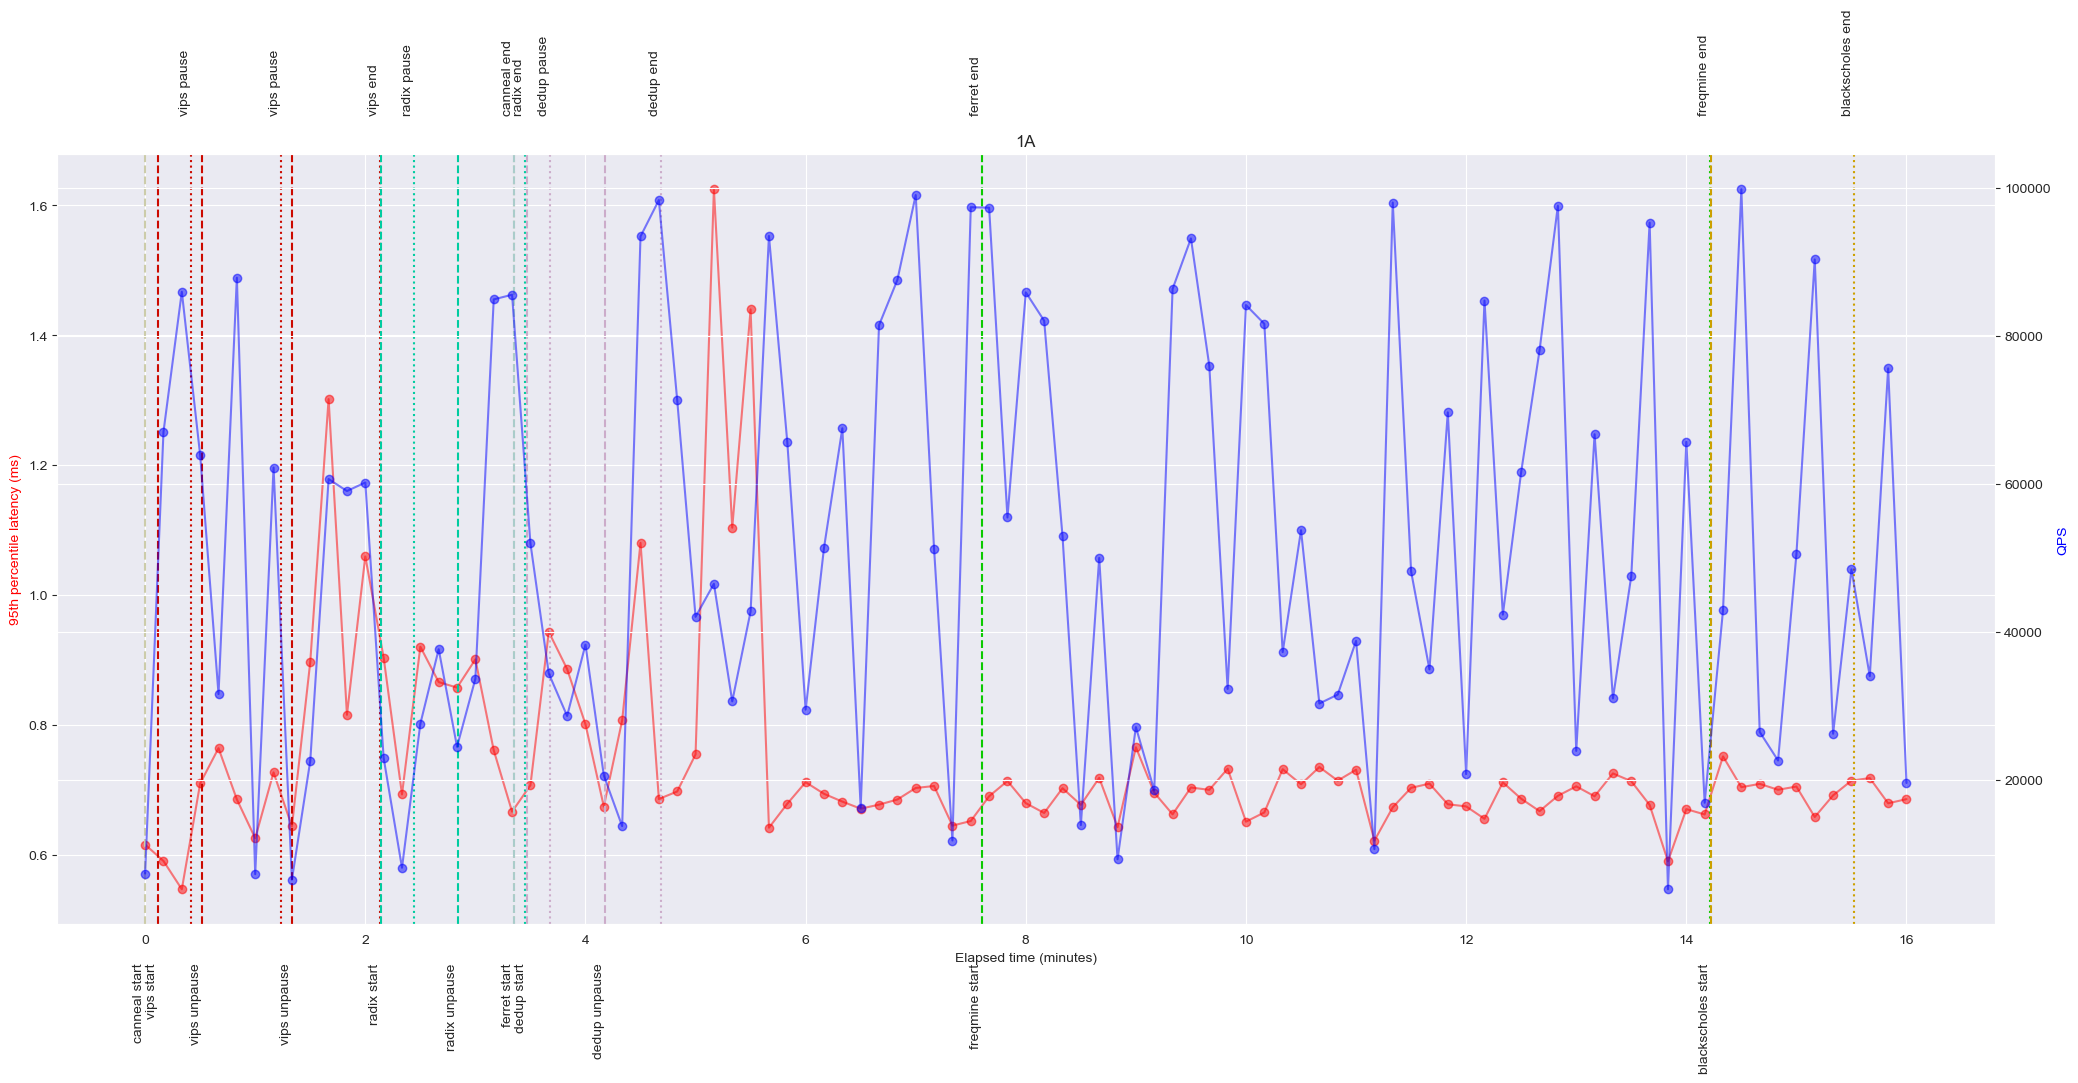

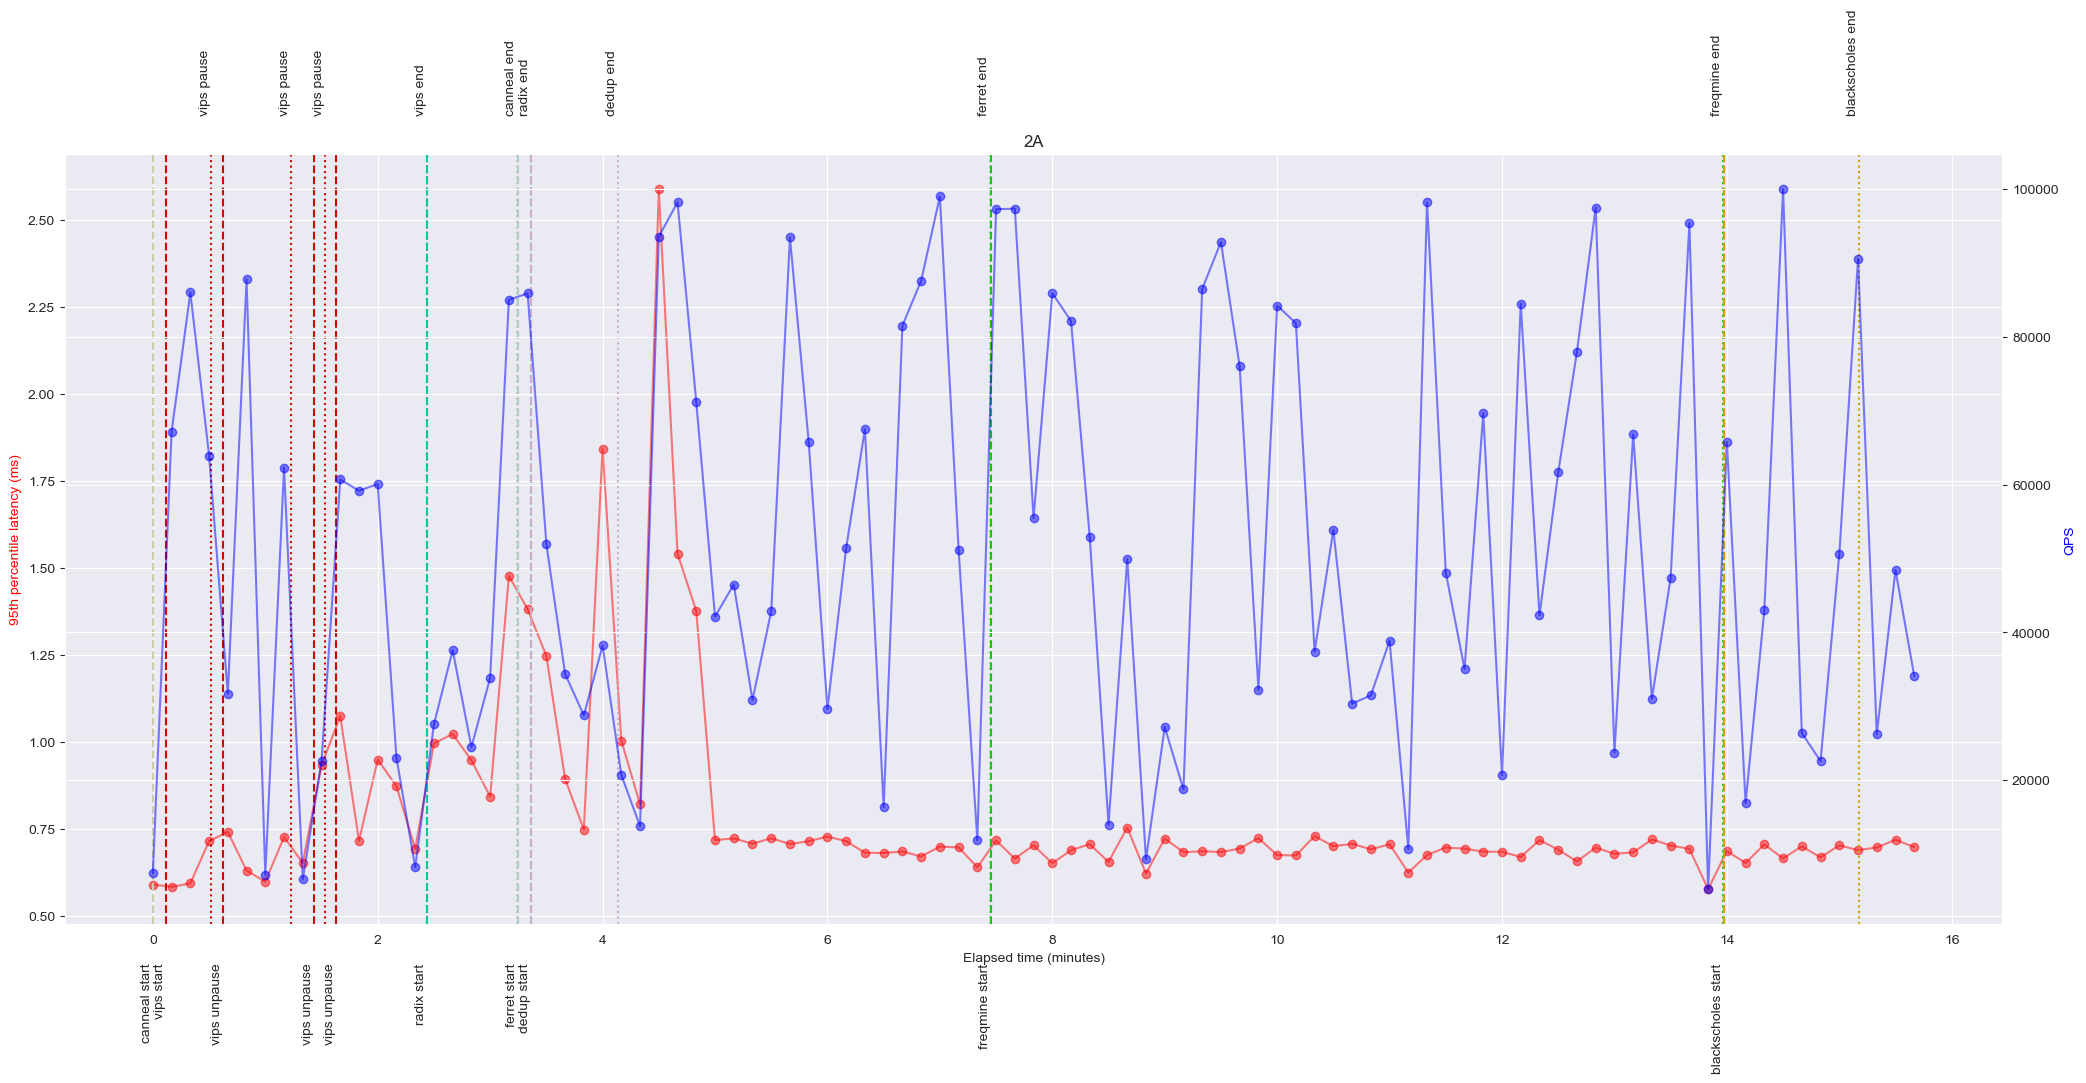

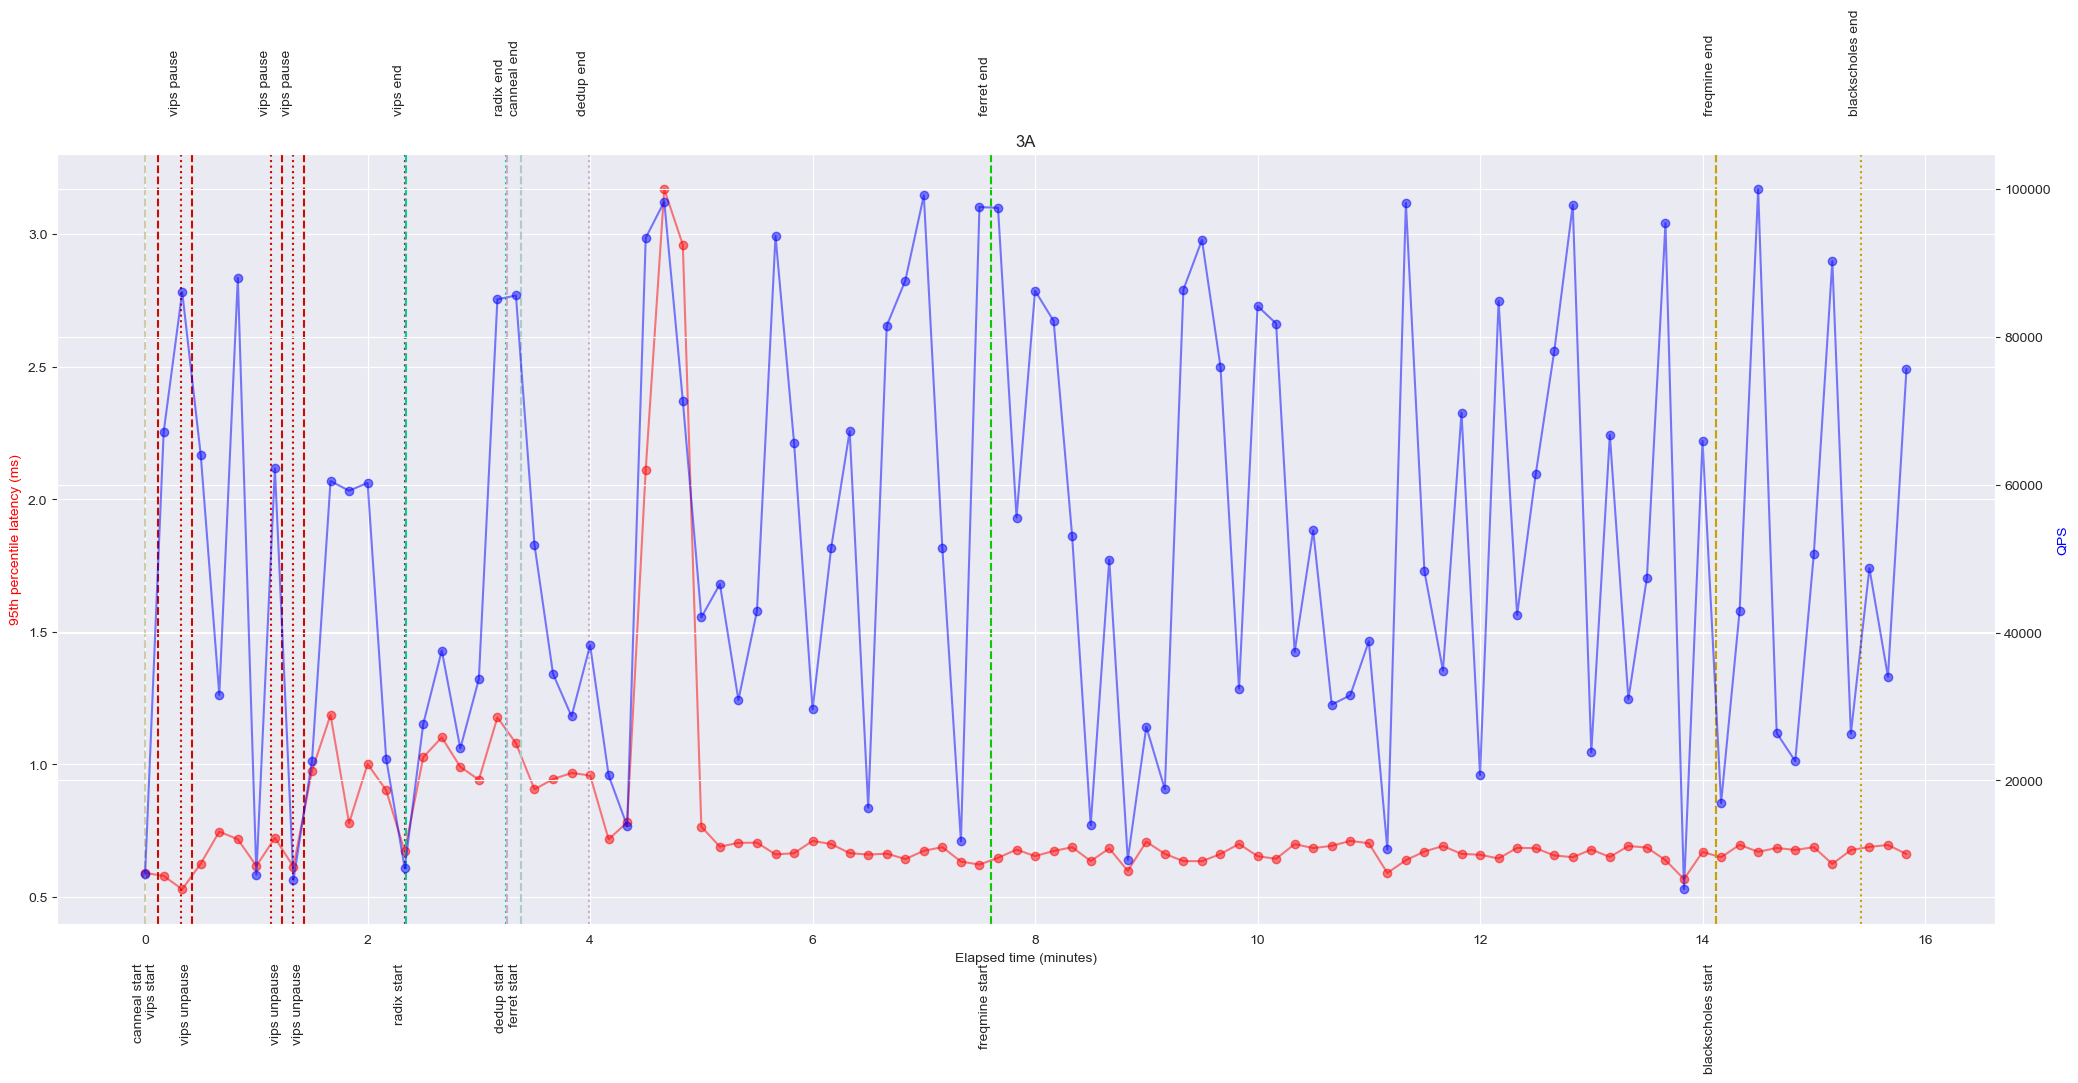

In [17]:
colors = {
    'blackscholes': '#CCA000',
    'canneal': '#CCCCAA',
    'dedup': '#CCACCA',
    'ferret': '#AACCCA',
    'freqmine': '#0CCA00',
    'radix': '#00CCA0',
    'vips': '#CC0A00'
}

# Set the style
sns.set_style("darkgrid")

for i in range(3):
    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(25, 10))
    mcperf_df = mcperf_dfs[i]
    
    # Get the 'log_run' DataFrame for this run
    log_run_df = log_run_dfs[i]

    # Get the last timestamp from the log_run_df
    last_timestamp = log_run_df['timestamp'].max()

    # Filter mcperf_df to include timestamps up to and including the first timestamp that is greater than the last timestamp
    # Find the index of the first timestamp in mcperf_df that is greater than the last timestamp
    first_greater_index = mcperf_df[mcperf_df['start'] > last_timestamp].index[0]

    # Filter mcperf_df to only include timestamps up to the first_greater_index
    mcperf_df = mcperf_df[mcperf_df.index <= first_greater_index]

    # Save mcperf_df to a CSV file including the index
    mcperf_df.to_csv(f'./Part4-4_Plots/run{i+1}/mcperf.csv', index=True)
    
    # Plot QPS against elapsed time on the right y-axis with circular markers
    ax2 = ax.twinx()
    ax2.plot(mcperf_df['elapsed_time'], mcperf_df['QPS'], marker='o', linestyle='-', color='blue', alpha=0.5)
    ax2.set_ylabel('QPS', color='blue')

    # Convert p95 from microseconds to milliseconds before plotting
    mcperf_df['p95'] = mcperf_df['p95'] / 1000

    # Plot the 95th percentile latency against elapsed time on the left y-axis with circular markers
    ax.plot(mcperf_df['elapsed_time'], mcperf_df['p95'], marker='o', linestyle='-', color='red', alpha=0.5)
    ax.set_ylabel('95th percentile latency (ms)', color='red')
    
    # Go through each job and plot vertical lines for start and end times
    for _, row in log_run_df.iterrows():
        if row['event'] not in ['start', 'end', 'pause', 'unpause']:
            continue 
        if row['event'] in ['start', 'unpause']:
            y_position = -0.05  # Slightly below the plot
            va = 'top'  # Vertical alignment
            ha = 'center'
            linestyle = 'dashed'
        else:
            y_position = 1.05  # Slightly above the plot
            va = 'bottom'  # Vertical alignment
            ha = 'center'
            linestyle = 'dotted'
        
        # Plot the vertical line
        ax.axvline(row['elapsed_time'], linestyle=linestyle, color=colors[row['job']])

        # Add the text
        ax.text(row['elapsed_time'], y_position, f"{row['job']} {row['event']}", transform=ax.get_xaxis_transform(), ha='right', va=va, rotation=90, fontsize=10)

    # Label the plot
    ax.set_title(f'{i+1}A')
    
    # Set the x-axis label
    ax.set_xlabel('Elapsed time (minutes)')

                    timestamp         event           job   cores  threads  \
0  2023-05-25 02:46:24.858494         start       canneal  [2, 3]      4.0   
1  2023-05-25 02:46:31.951398         start          vips     [1]      4.0   
2  2023-05-25 02:46:50.003221  update_cores     memcached  [0, 1]      NaN   
3  2023-05-25 02:46:50.028541         pause          vips    None      NaN   
4  2023-05-25 02:46:56.059810  update_cores     memcached     [0]      NaN   
5  2023-05-25 02:46:56.080882       unpause          vips    None      NaN   
6  2023-05-25 02:47:38.814582  update_cores     memcached  [0, 1]      NaN   
7  2023-05-25 02:47:38.853055         pause          vips    None      NaN   
8  2023-05-25 02:47:44.874557  update_cores     memcached     [0]      NaN   
9  2023-05-25 02:47:44.899804       unpause          vips    None      NaN   
10 2023-05-25 02:48:33.074953           end          vips    None      NaN   
11 2023-05-25 02:48:33.424434         start         radix     [1

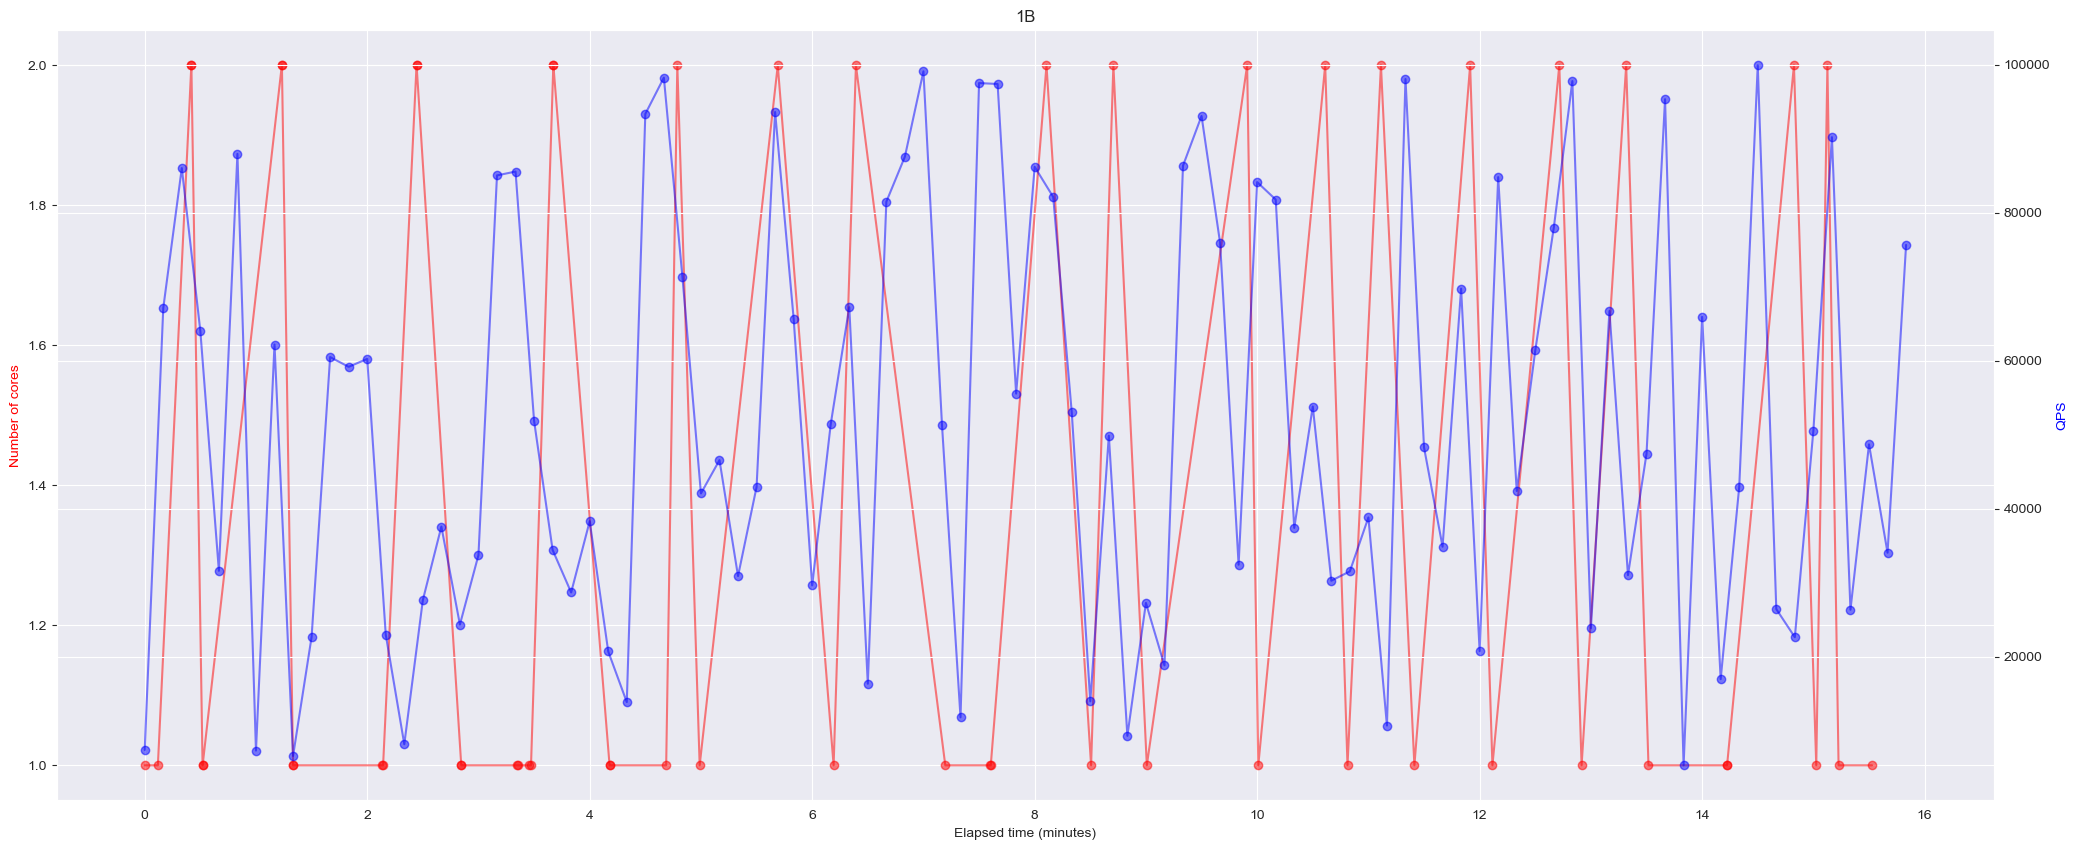

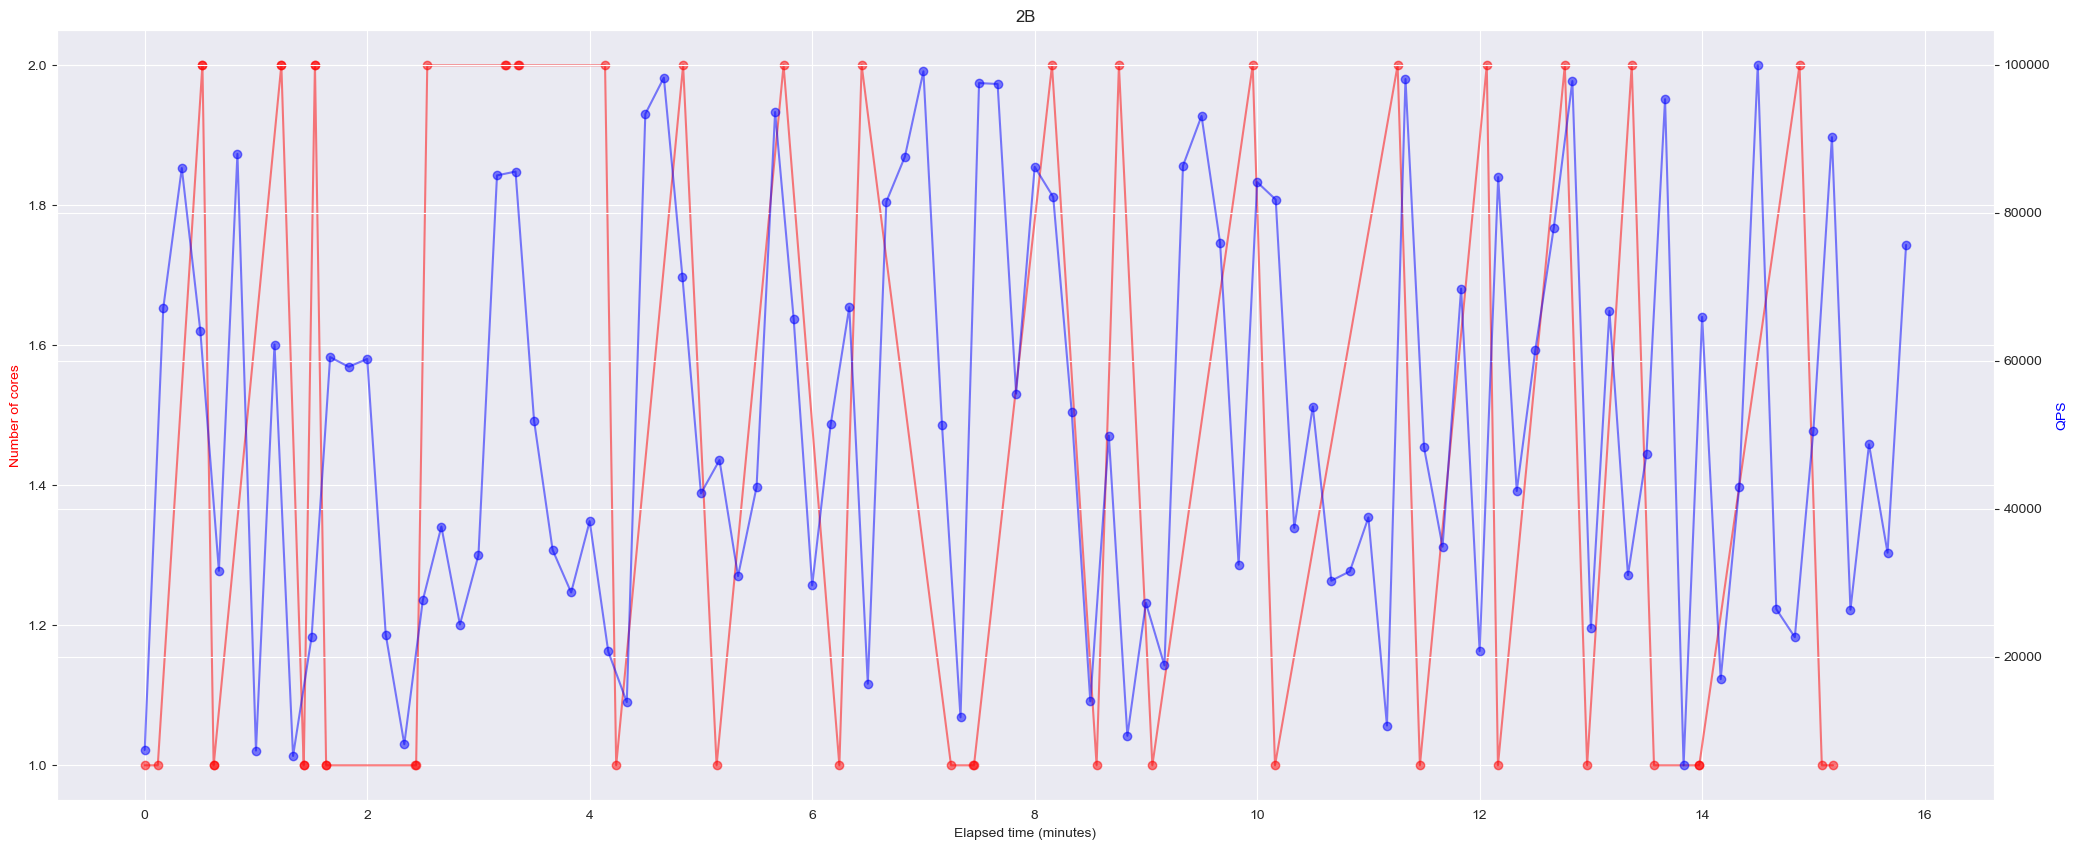

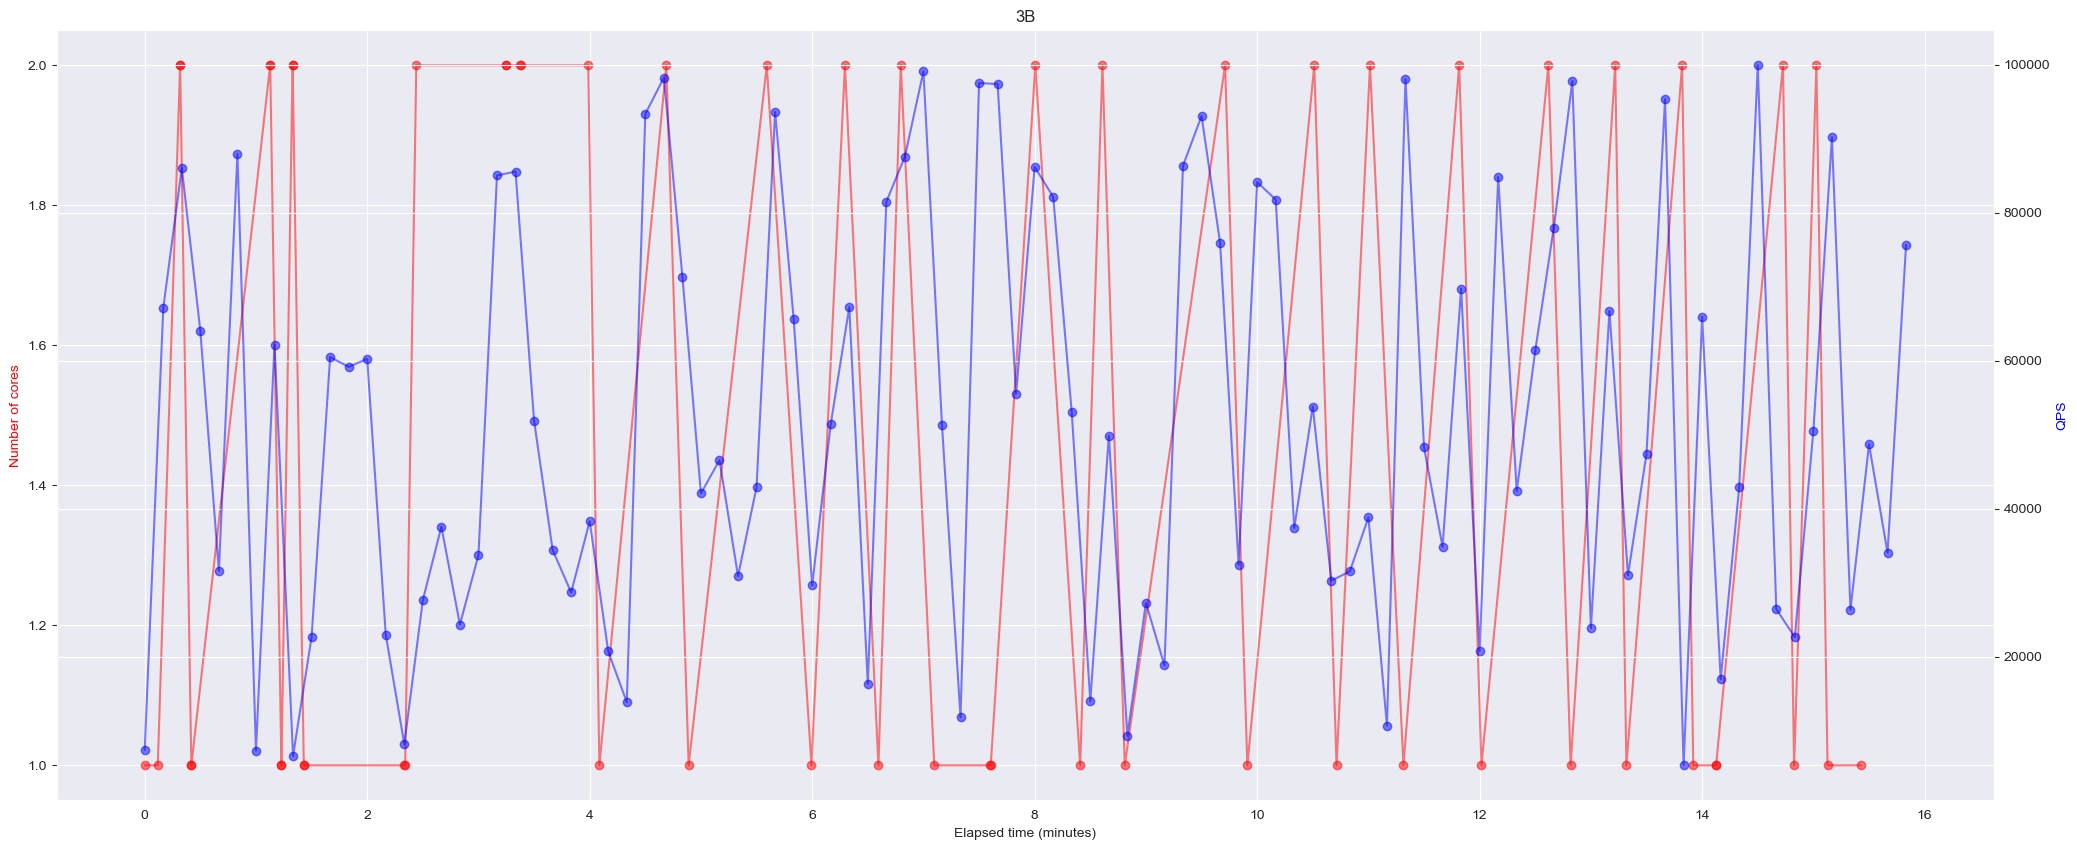

In [18]:
# Set the style
sns.set_style("darkgrid")

for i in range(3):
    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(25, 10))
    
    # Get the 'log_run' DataFrame for this run
    log_run_df = log_run_dfs[i]
    print(log_run_df)
    
    # Create a new DataFrame with a single row
    initial_row = pd.DataFrame({
        'timestamp': [log_run_df['timestamp'].min()], 
        'event': ['update_cores'], 
        'job': ['memcached'], 
        'cores': [[0]], 
        'num_cores': [1]
    })

    # Append the original DataFrame to the new DataFrame
    log_run_df = pd.concat([initial_row, log_run_df]).reset_index(drop=True)

    # Plot QPS against elapsed time on the right y-axis with circular markers
    ax2 = ax.twinx()
    ax2.plot(mcperf_df['elapsed_time'], mcperf_df['QPS'], marker='o', linestyle='-', color='blue', alpha=0.5)
    ax2.set_ylabel('QPS', color='blue')

    # Plot the number of cores used against elapsed time on the left y-axis
    # Assuming "detail" of update_cores events contains the new cores as a list
    log_run_df['num_cores'] = log_run_df[log_run_df['event'] == 'update_cores']['cores'].apply(lambda x: len(x) if x else 1)
    log_run_df['num_cores'] = log_run_df['num_cores'].fillna(method='ffill')
    ax.plot(log_run_df['elapsed_time'], log_run_df['num_cores'], marker='o', color='red', alpha=0.5)
    ax.set_ylabel('Number of cores', color='red')

    # Label the plot
    ax.set_title(f'{i+1}B')
    
    # Set the x-axis label
    ax.set_xlabel('Elapsed time (minutes)')